In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

# Analysis of Real Estate Data

In [2]:
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

In [3]:
rent_df['living_area'] = rent_df['living_area'].astype(np.float64)
rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df['lot_area'] = rent_df['lot_area'].astype(np.float64)
rent_df['area'] = rent_df['area'].astype(np.float64)
rent_df['beds'] = rent_df['beds'].astype(np.float64)
rent_df['baths'] = rent_df['baths'].astype(np.float64)
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id'], axis=1)

The structure of the data is:

In [4]:
rent_df

,date,event_description,price,address_city,zip_code,area,status_type,home_type,beds,baths,living_area,lot_area,borough
0,2021-04-16,Listed for rent,1500,Maspeth,11378.0,NaN,FOR_RENT,APARTMENT,1.0,1.0,NaN,NaN,queens
1,2021-03-03,Price change,1300,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
2,2021-02-17,Listed for rent,1350,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
3,2021-04-10,Listed for rent,3000,Maspeth,11378.0,NaN,FOR_RENT,MULTI_FAMILY,3.0,1.0,NaN,NaN,queens
4,2021-03-23,Listed for rent,3200,Flushing,11378.0,3000.0,FOR_RENT,SINGLE_FAMILY,3.0,2.5,3000.0,2500.0,queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48316,2021-03-13,No price history,2500,Bayside,11361.0,1100.0,FOR_RENT,APARTMENT,3.0,1.5,1100.0,NaN,queens
48317,2021-03-12,No price history,2400,Bayside,11361.0,NaN,FOR_RENT,APARTMENT,4.0,2.0,NaN,NaN,queens
48318,2021-02-01,No price history,2299,Bayside,11361.0,1000.0,FOR_RENT,MULTI_FAMILY,3.0,2.0,1000.0,NaN,queens
48319,2021-01-04,No price history,2274,Bayside,11361.0,NaN,FOR_RENT,MULTI_FAMILY,1.0,1.0,NaN,NaN,queens


Our analysis starts from 06/01/2019 so we need to remove the properties with a date
before 06/01/2019

In [5]:
start = datetime.datetime(2019, 6, 1)
end = datetime.datetime(2021, 4, 1)
rent_df = rent_df[(rent_df['date'] >= start) & (rent_df['date'] <= end)]

We divide the data into boroughs to analyze them individually

In [6]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

# Time Series Analysis on Manhattan

In [7]:
manhattan_df = rent_ny['manhattan']
print(manhattan_df['price'].describe())

count    12620.000000
mean      3494.927258
std       2179.796099
min        500.000000
25%       2075.000000
50%       2700.000000
75%       3995.000000
max      15000.000000
Name: price, dtype: float64


Remove outliers from the data

In [8]:
manhattan_df.drop(manhattan_df[manhattan_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
idx = pd.date_range(start, end)
manhattan_ts = manhattan_df.groupby(manhattan_df.date)['price'].agg(['mean','count', 'median'])
manhattan_ts.index = pd.DatetimeIndex(manhattan_ts.index)
manhattan_ts = manhattan_ts.reindex(idx)
manhattan_ts

,mean,count,median
2019-06-01,3200.000000,1.0,3200.0
2019-06-02,NaN,NaN,NaN
2019-06-03,4247.500000,2.0,4247.5
2019-06-04,2800.000000,1.0,2800.0
2019-06-05,3721.000000,3.0,2850.0
...,...,...,...
2021-03-28,2895.207048,227.0,2500.0
2021-03-29,2885.548822,297.0,2500.0
2021-03-30,2941.651297,347.0,2600.0
2021-03-31,2841.966245,237.0,2500.0


Plot of the raw time series for Manhattan

<AxesSubplot:>

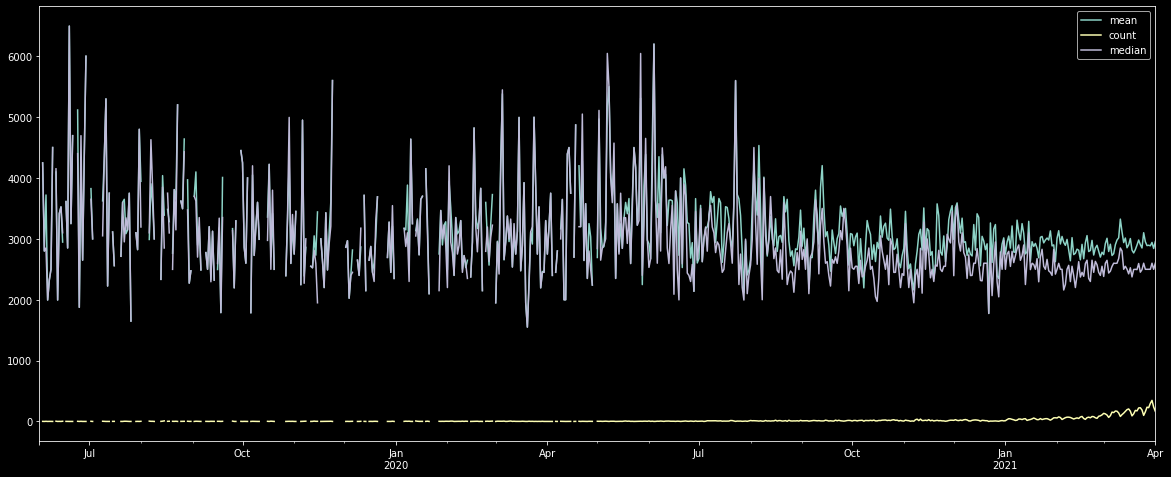

In [10]:
manhattan_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [11]:
manhattan_ts = manhattan_ts.interpolate(method='spline', order=2)


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

<AxesSubplot:>

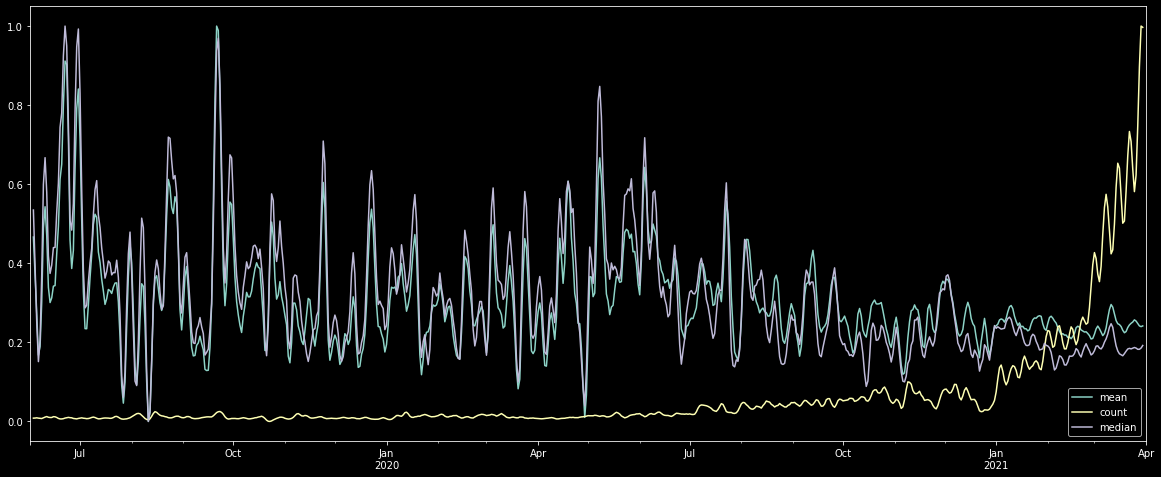

In [12]:
scaler = MinMaxScaler()
smoothed_df = manhattan_ts.rolling(5, win_type='triang', center=True).mean()
smoothed_df = pd.DataFrame(scaler.fit_transform(smoothed_df), index=smoothed_df.index, columns=smoothed_df.columns)
smoothed_df.plot()

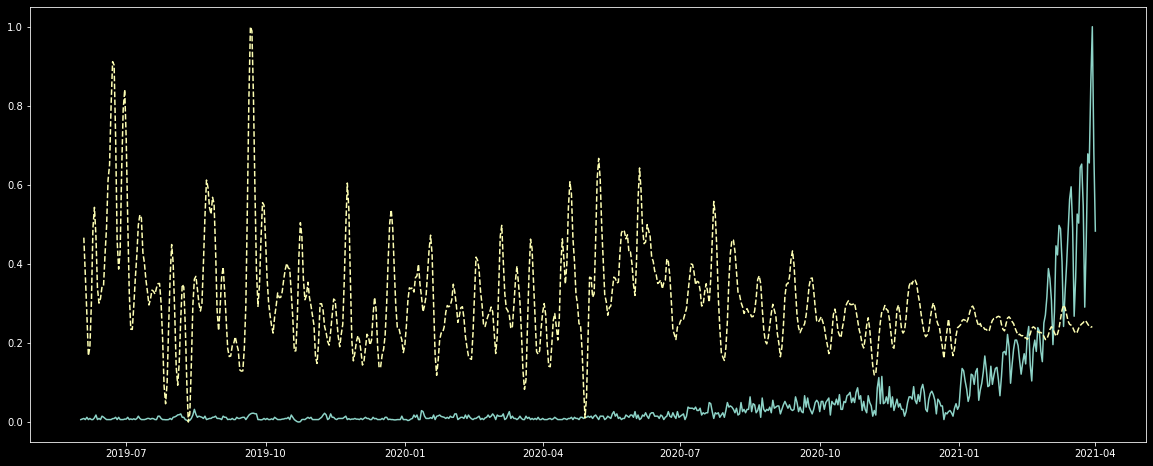

In [13]:
plt.plot(manhattan_ts.index, scaler.fit_transform(manhattan_ts[['count']]))
plt.plot(smoothed_df.index, smoothed_df['mean'], ls='--')
plt.show()

We now explore the price/sqr_feet instead of just the price.

In [14]:
price_sqft = manhattan_df[~manhattan_df['area'].isna()].sort_values('date')
price_sqft['price_per_area'] = price_sqft['price']/price_sqft['area']

<AxesSubplot:xlabel='date'>

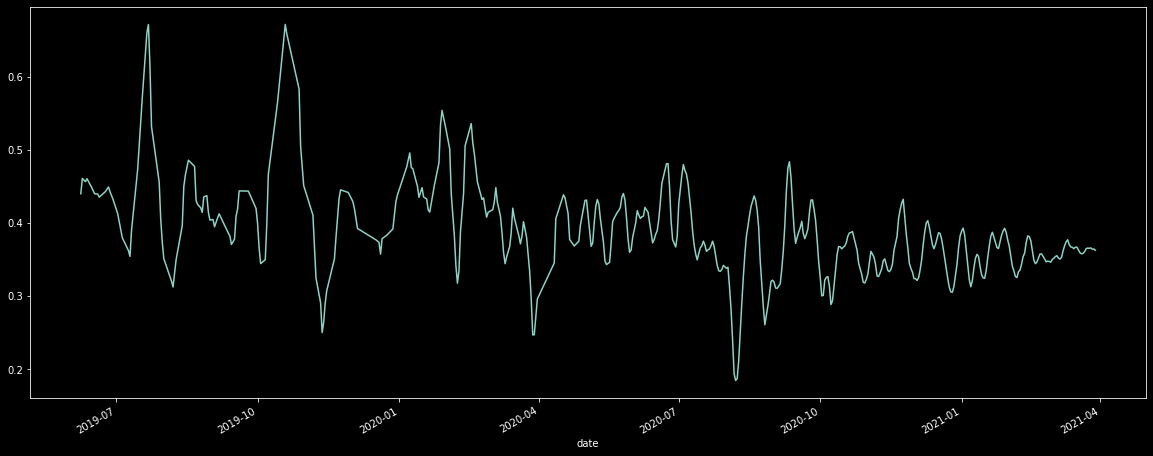

In [15]:
modified_manhattan_ts = price_sqft.groupby(price_sqft.date)['price_per_area'].agg(['mean', 'max', 'min', 'median'])
modified_manhattan_ts = modified_manhattan_ts.interpolate(method='spline', order=2)
modified_manhattan_ts = pd.DataFrame(scaler.fit_transform(modified_manhattan_ts), index=modified_manhattan_ts.index, columns=modified_manhattan_ts.columns)
modified_manhattan_ts = modified_manhattan_ts.rolling(7, win_type='triang', center=True).mean()
modified_manhattan_ts['mean'].plot()

# Introducing COVID data

In [16]:
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_df = nyc_covid_df.set_index('date', drop=True)

Covid raw data: 

<AxesSubplot:xlabel='date'>

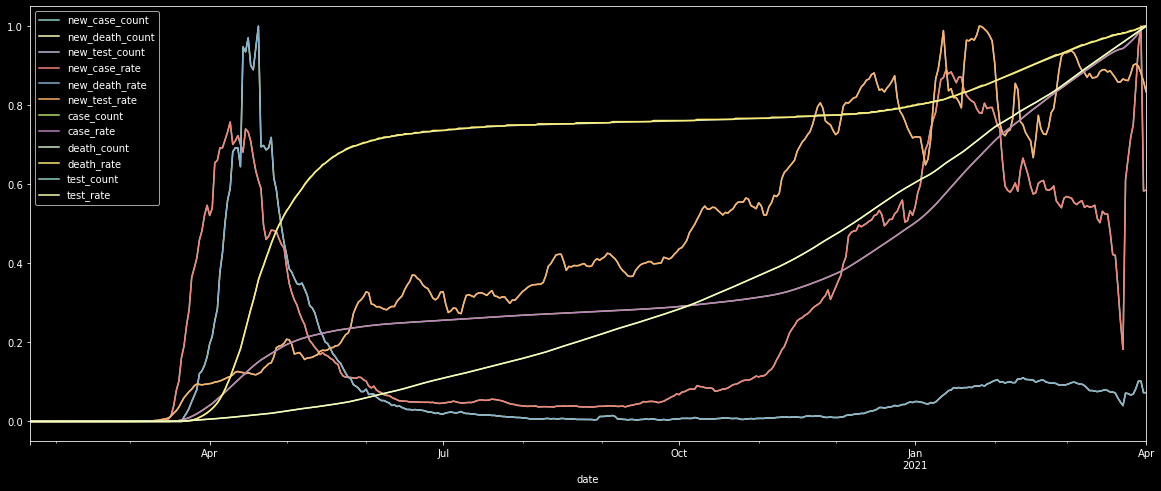

In [17]:
nyc_covid_df = pd.DataFrame(scaler.fit_transform(nyc_covid_df), columns=nyc_covid_df.columns, index=nyc_covid_df.index)
nyc_covid_df.plot()

In [37]:
outp_df = pd.read_csv("data/covid/output.csv")

outp_df = outp_df[outp_df['BOROUGH_GROUP'] == 'Manhattan']
outp_df['date'] = pd.to_datetime(outp_df['date'])
outp_df = outp_df[['date', 'COVID_CASE_COUNT', 'COVID_CASE_RATE', 'POP_DENOMINATOR', 'COVID_DEATH_COUNT', 'COVID_DEATH_RATE', 'PERCENT_POSITIVE']]
case_rate_out_df = outp_df.groupby('date')['COVID_CASE_RATE'].agg(['mean','count', 'median'])
case_rate_out_df = pd.DataFrame(scaler.fit_transform(case_rate_out_df), columns=case_rate_out_df.columns, index=case_rate_out_df.index)

<AxesSubplot:xlabel='date'>

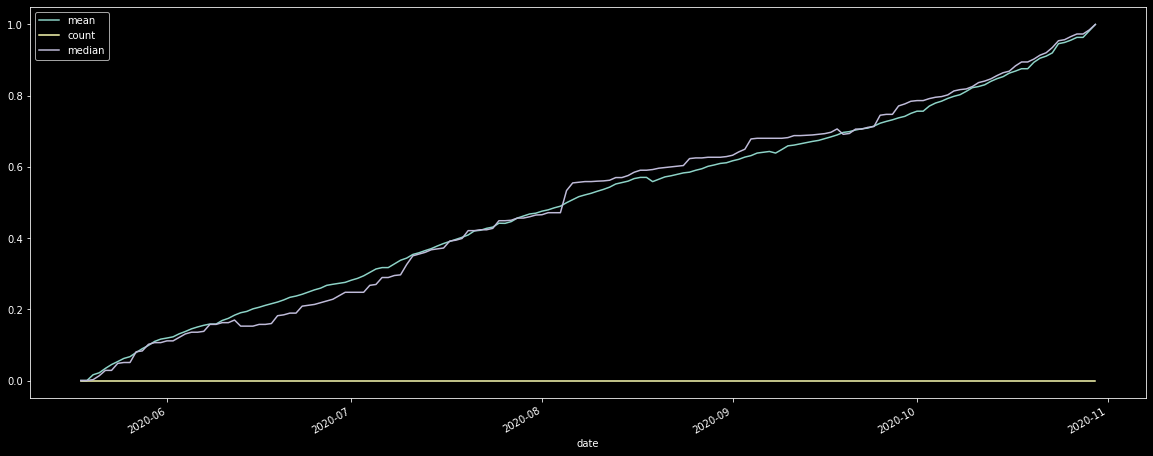

In [38]:
case_rate_out_df.plot()


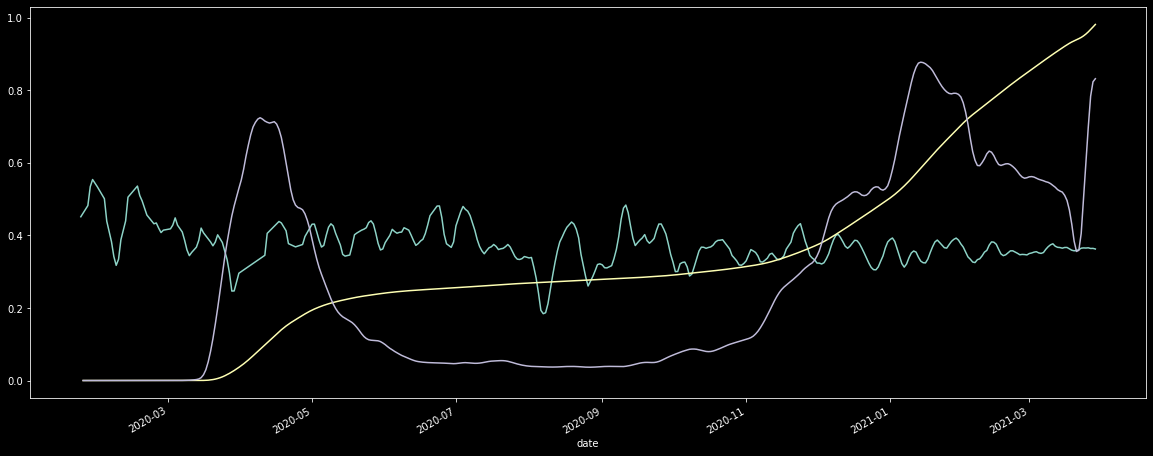

In [21]:
new_case_rate = nyc_covid_df['new_case_rate'].rolling(7, win_type='triang', center=True).mean()
case_rate = nyc_covid_df['case_rate'].rolling(7, win_type='triang', center=True).mean()

<AxesSubplot:xlabel='date'>

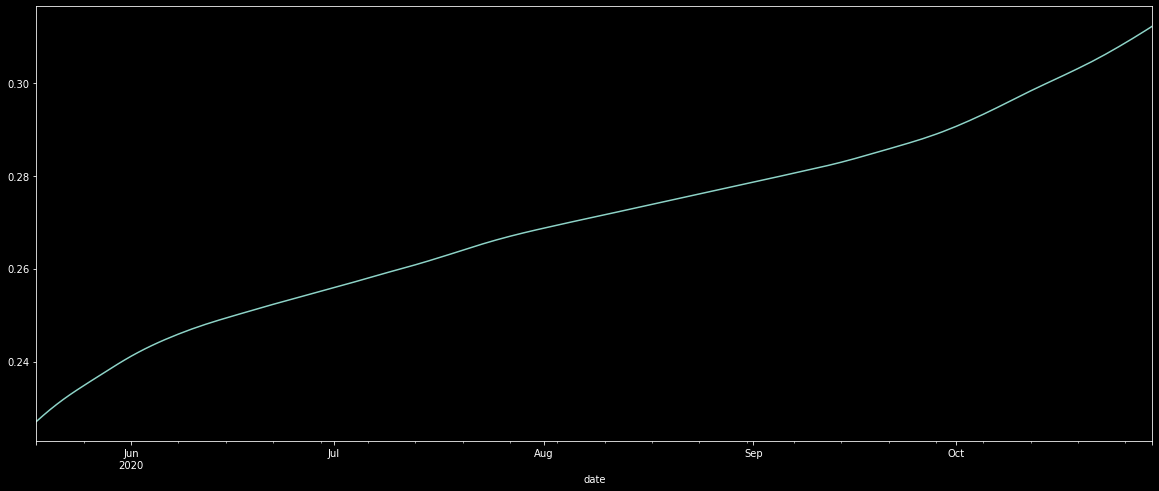

In [40]:
case_rate[(case_rate.index <= case_rate_out_df.index.max()) & (case_rate.index >= case_rate_out_df.index.min())].plot()



In [ ]:

plt.figure()
modified_manhattan_ts[modified_manhattan_ts.index >= case_rate.index.min()]['mean'].plot()
case_rate.plot()
new_case_rate.plot()
plt.show()

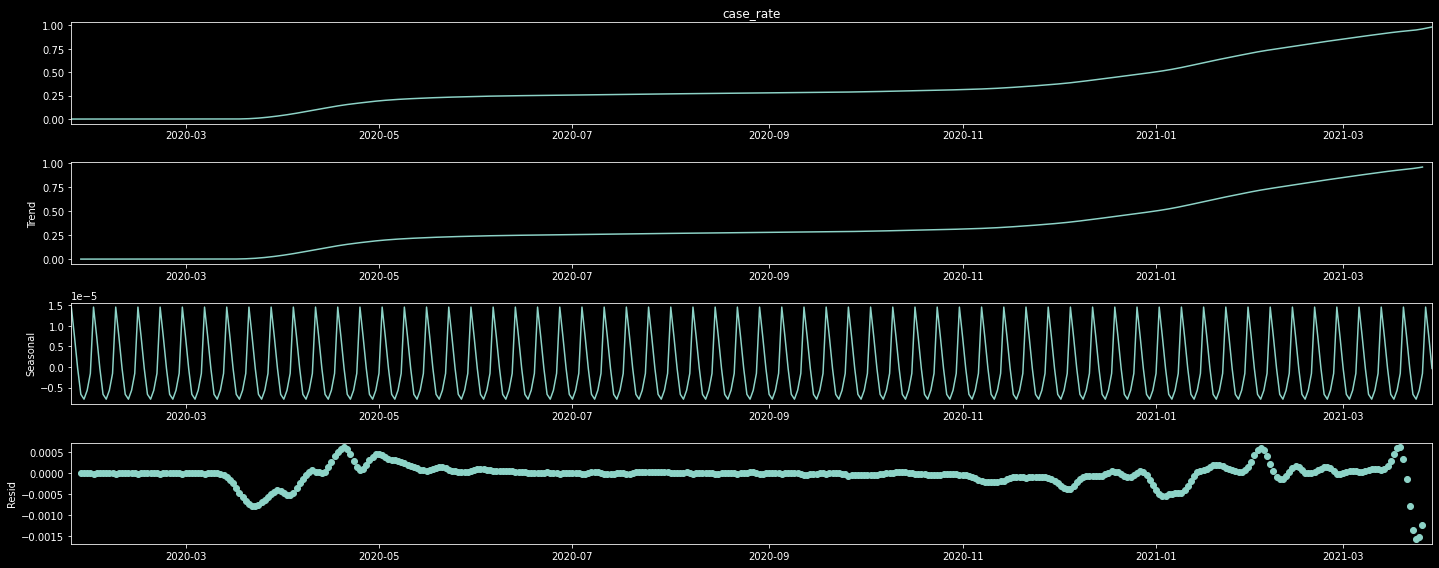

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(case_rate.drop(case_rate[case_rate.isna()].index), model='additive')
result.plot()
plt.show()

<AxesSubplot:>

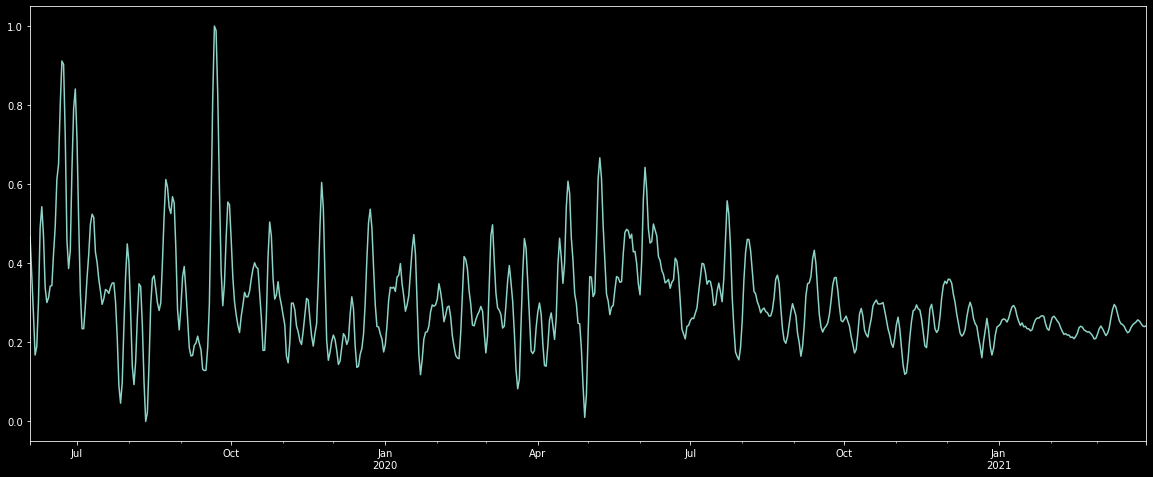

In [23]:
smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index).plot()

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index), model='additive')

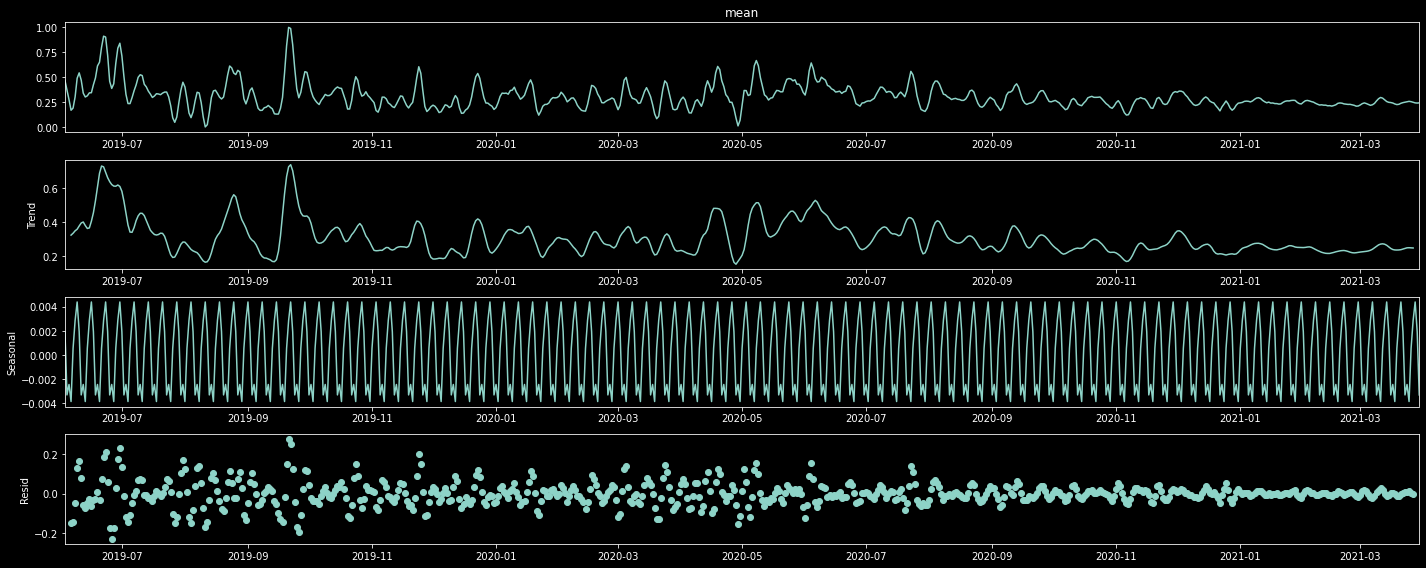

In [25]:
result.plot()
plt.show()